<a href="https://colab.research.google.com/github/glorivaas/Machine_Learning25/blob/main/Lab13and14.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#LAB 13 - **Towards self-attention**
## *Last homework: finding odd shapes*
###**AUTHOR**: Gloria Rivas

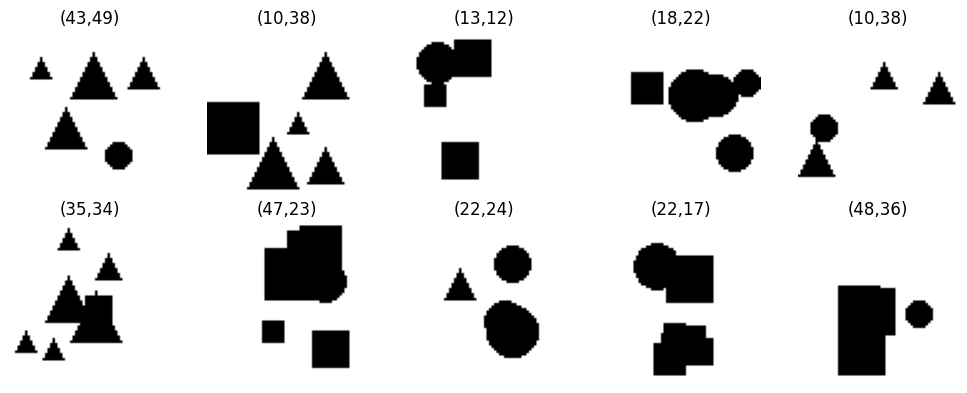

In [68]:
# ============================================================
# 0. Imports & device
# ============================================================
import torch, random, math, numpy as np
from torch import nn
from torch.utils.data import Dataset, DataLoader
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# ============================================================
# 1. Online dataset: 64×64, target = (cx,cy) ∈ [0,63]²  (float32)
# ============================================================
IMAGE = 64
SHAPES = ("circle", "square", "triangle")

def draw_shape(drawer, shape_type, center_x, center_y, radius):
    if shape_type == "circle":
        drawer.ellipse([center_x - radius, center_y - radius,
                        center_x + radius, center_y + radius], fill="black")
    elif shape_type == "square":
        drawer.rectangle([center_x - radius, center_y - radius,
                          center_x + radius, center_y + radius], fill="black")
    else:  # triangle
        drawer.polygon([
            (center_x, center_y - radius),
            (center_x - radius, center_y + radius),
            (center_x + radius, center_y + radius)
        ], fill="black")

class OddXYDataset(Dataset):
    """
    Generates images on-the-fly:
      * several random shapes of the same type
      * 1 additional shape of a different type
    Returns:
      * image (1×64×64 tensor, float32 normalized to [0,1])
      * label: float tensor [cx, cy] with center of the odd shape
    Arguments:
        num_samples             – total number of samples in the dataset
        same_shape_count_range – tuple (min, max), number of identical shapes
        shape_radius_range      – tuple (min_radius, max_radius) for shape size
    """
    def __init__(self,
                 num_samples,
                 same_shape_count_range=(3, 6),
                 shape_radius_range=(4, 10)):
        self.num_samples = num_samples
        self.same_shape_count_range = same_shape_count_range
        self.radius_min, self.radius_max = shape_radius_range

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        base_shape = random.choice(SHAPES)
        odd_shape = random.choice([s for s in SHAPES if s != base_shape])

        img = Image.new("L", (IMAGE, IMAGE), "white")
        drawer = ImageDraw.Draw(img)

        # draw identical shapes
        for _ in range(random.randint(*self.same_shape_count_range)):
            radius = random.randint(self.radius_min, self.radius_max)
            cx = random.randint(radius, IMAGE - radius - 1)
            cy = random.randint(radius, IMAGE - radius - 1)
            draw_shape(drawer, base_shape, cx, cy, radius)

        # draw the odd shape (with known center)
        radius = random.randint(self.radius_min, self.radius_max)
        cx = random.randint(radius, IMAGE - radius - 1)
        cy = random.randint(radius, IMAGE - radius - 1)
        draw_shape(drawer, odd_shape, cx, cy, radius)

        img_tensor = torch.tensor(np.array(img), dtype=torch.float32).unsqueeze(0) / 255.
        label_tensor = torch.tensor([float(cx), float(cy)], dtype=torch.float32)
        return img_tensor, label_tensor

def show_examples(num_examples=10):
    """
    Displays a grid of image samples from OddXYDataset using a DataLoader with batch_size=1.

    Args:
        num_examples (int): Number of examples to display.
    """
    dataset = OddXYDataset(num_samples=num_examples)
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

    num_columns = 5
    num_rows = math.ceil(num_examples / num_columns)

    fig, axes = plt.subplots(num_rows, num_columns, figsize=(num_columns * 2, num_rows * 2))

    for i, (image, label) in enumerate(dataloader):
        if i >= num_examples:
            break
        image_np = image.squeeze(0).squeeze(0).numpy()  # B=1,C=1,H,W --> H,W
        cx, cy = label.squeeze(0)                       # B=1,2       --> 2
        axes.flat[i].imshow(image_np, cmap="gray")
        axes.flat[i].set_title(f"({cx:.0f},{cy:.0f})")
        axes.flat[i].axis("off")

    for j in range(i + 1, num_rows * num_columns):
        axes.flat[j].axis("off")

    plt.tight_layout()
    plt.show()



show_examples()

##STEP 1: Embedding

In [69]:
import torch
import torch.nn as nn

class PatchEmbedding(nn.Module):
    """
    Converts a [B, 1, 64, 64] image into [B, 144, 16] patch embeddings
    using a single convolution layer.
    """
    def __init__(self):
        super().__init__()
        self.proj = nn.Conv2d(
            in_channels=1, out_channels=16,
            kernel_size=20, stride=4, padding=0
        )

    def forward(self, x):
        """
        x: [B, 1, 64, 64]
        returns: [B, 144, 16]
        """
        x = self.proj(x)                   # [B, 16, 12, 12]
        x = x.flatten(2)                   # [B, 16, 144]
        x = x.transpose(1, 2)              # [B, 144, 16]
        return x


Example of usage:

In [70]:
model = PatchEmbedding()
dummy_input = torch.randn(8, 1, 64, 64)
out = model(dummy_input)
print(out.shape)


torch.Size([8, 144, 16])


##STEP 2: Sinusoidal Positional Encoding

In [71]:
import math

class PositionalEncoding(nn.Module):
    """
    Adds sinusoidal positional encoding to patch embeddings.

    Input:  [B, 144, 16]
    Output: [B, 144, 16]
    """
    def __init__(self, num_positions=144, d_model=16):
        super().__init__()
        self.encoding = self._build_encoding(num_positions, d_model)  # [144, 16]
        self.encoding = self.encoding.unsqueeze(0)  # [1, 144, 16]

    def _build_encoding(self, num_positions, d_model):
        pe = torch.zeros(num_positions, d_model)
        position = torch.arange(0, num_positions).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)  # even indices
        pe[:, 1::2] = torch.cos(position * div_term)  # odd indices
        return pe

    def forward(self, x):
        """
        x: [B, 144, 16]
        return: [B, 144, 16]
        """
        return x + self.encoding.to(x.device)


Example usage:

In [72]:
embedder = PatchEmbedding()
pos_enc = PositionalEncoding()

dummy_input = torch.randn(8, 1, 64, 64)
x = embedder(dummy_input)        # [8, 144, 16]
x = pos_enc(x)                   # [8, 144, 16] + positional encoding

##STEP 3 - Attention

In [73]:
class SelfAttention(nn.Module):
    def __init__(self, dim=16):
        super().__init__()
        self.to_q = nn.Linear(dim, dim, bias=False)
        self.to_k = nn.Linear(dim, dim, bias=False)
        self.to_v = nn.Linear(dim, dim, bias=False)
        self.scale = dim ** -0.5
        self.attn_weights = None  # <-- store for visualization

    def forward(self, x):  # x: [B, N=144, D]
        Q = self.to_q(x)  # [B, N, D]
        K = self.to_k(x)  # [B, N, D]
        V = self.to_v(x)  # [B, N, D]

        attn_logits = Q @ K.transpose(-2, -1) * self.scale  # [B, N, N]
        attn = attn_logits.softmax(dim=-1)                 # [B, N, N]

        self.attn_weights = attn.detach().cpu()

        return attn @ V                    # [B, N, D]



Example usage:

In [74]:
embed = PatchEmbedding()
posenc = PositionalEncoding()
attn   = SelfAttention()

x = embed(torch.randn(4, 1, 64, 64))   # [4, 144, 16]
x = posenc(x)                          # [4, 144, 16]
x = attn(x)                            # [4, 144, 16]


##STEP 4 - Post-Processing via a Token-Wise Classifier.

In [75]:
class TokenClassifier(nn.Module):
    """
    Classifies each of the 144 tokens independently with a deeper MLP.
    Input:  [B, 144, 16]
    Output: [B, 144] (logits)
    """
    def __init__(self, hidden_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(16, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)  # 1 logit per token
        )

    def forward(self, x):
        logits = self.net(x)         # [B, 144, 1]
        return logits.squeeze(-1)    # [B, 144]

Example usage:

In [76]:
embedder = PatchEmbedding()
posenc = PositionalEncoding()
attention = SelfAttention()
classifier = TokenClassifier()

img = torch.randn(4, 1, 64, 64)
x = classifier(attention(posenc(embedder(img))))  # [4, 144]

# Convert to softmax probabilities
probs = torch.softmax(x, dim=-1)  # [4, 144]
print("Per-position probabilities shape:", probs.shape)


Per-position probabilities shape: torch.Size([4, 144])


##STEP 5 - Soft Argmax

In [77]:
def compute_patch_centers(image_size=64, patch_size=20, stride=4):
    centers = []
    for y in range(0, image_size - patch_size + 1, stride):
        for x in range(0, image_size - patch_size + 1, stride):
            cx = x + patch_size // 2
            cy = y + patch_size // 2
            centers.append((cx, cy))
    return torch.tensor(centers, dtype=torch.float32)  # [144, 2]


def soft_argmax(probabilities, centers):
    """
    Args:
        probabilities: [B, 144] - softmaxed logits
        centers: [144, 2]       - (cx, cy) per patch
    Returns:
        coords: [B, 2] - predicted (x, y)
    """
    B = probabilities.shape[0]
    weighted = torch.einsum('bn,nc->bc', probabilities, centers.to(probabilities.device))
    return weighted  # [B, 2]


Example usage:

In [78]:
centers = compute_patch_centers()  # [144, 2]
pred_coords = soft_argmax(probs, centers)  # [B, 2]
print("Predicted (x, y) locations:", pred_coords)


Predicted (x, y) locations: tensor([[32.0016, 32.0028],
        [32.0007, 31.9992],
        [32.0001, 32.0025],
        [32.0001, 32.0007]], grad_fn=<ViewBackward0>)


##**MODEL PREPARING**

In [79]:
class ShapeAttentionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = PatchEmbedding()               # [B, 1, 64, 64] → [B, 144, 16]
        self.pos_enc = PositionalEncoding()             # [B, 144, 16] + pos
        self.attn = SelfAttention()                     # → [B, 144, 16]
        self.classifier = TokenClassifier()             # → [B, 144] (logits)

        # Precompute receptive field centers (used in soft argmax)
        self.centers = compute_patch_centers()          # [144, 2]

    def forward(self, x):
        """
        x: [B, 1, 64, 64]
        Returns:
            coords: [B, 2] — predicted (x, y) position
        """
        x = self.embedding(x)                           # [B, 144, 16]
        x = self.pos_enc(x)                             # [B, 144, 16]
        x = self.attn(x)                                # [B, 144, 16]
        logits = self.classifier(x)                     # [B, 144]
        probs = torch.softmax(logits, dim=-1)           # [B, 144]
        pred_coords = soft_argmax(probs, self.centers)  # [B, 2]
        return pred_coords


##**TRAINING STEP**

In [80]:
import torch.optim as optim
import random
from torch.utils.data import DataLoader
from tqdm import tqdm

SEED = 1234
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

model = ShapeAttentionModel().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

train_dataset = OddXYDataset(num_samples=20000)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)


In [81]:
def train(model, dataloader, optimizer, criterion, epochs):
    model.train()
    loss_history = []

    for epoch in range(epochs):
        total_loss = 0
        for images, labels in tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}"):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            preds = model(images)
            loss = criterion(preds, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        loss_history.append(avg_loss)
        print(f"Epoch {epoch+1} — Avg Loss: {avg_loss:.4f}")

    return loss_history


Epoch 1/40: 100%|██████████| 313/313 [00:20<00:00, 15.33it/s]


Epoch 1 — Avg Loss: 184.1684


Epoch 2/40: 100%|██████████| 313/313 [00:19<00:00, 16.08it/s]


Epoch 2 — Avg Loss: 180.1604


Epoch 3/40: 100%|██████████| 313/313 [00:20<00:00, 15.01it/s]


Epoch 3 — Avg Loss: 178.4044


Epoch 4/40: 100%|██████████| 313/313 [00:19<00:00, 15.81it/s]


Epoch 4 — Avg Loss: 177.4787


Epoch 5/40: 100%|██████████| 313/313 [00:20<00:00, 15.16it/s]


Epoch 5 — Avg Loss: 171.3361


Epoch 6/40: 100%|██████████| 313/313 [00:19<00:00, 15.97it/s]


Epoch 6 — Avg Loss: 168.8889


Epoch 7/40: 100%|██████████| 313/313 [00:20<00:00, 15.62it/s]


Epoch 7 — Avg Loss: 162.7184


Epoch 8/40: 100%|██████████| 313/313 [00:20<00:00, 15.44it/s]


Epoch 8 — Avg Loss: 155.7443


Epoch 9/40: 100%|██████████| 313/313 [00:19<00:00, 15.80it/s]


Epoch 9 — Avg Loss: 152.8332


Epoch 10/40: 100%|██████████| 313/313 [00:20<00:00, 15.46it/s]


Epoch 10 — Avg Loss: 149.1643


Epoch 11/40: 100%|██████████| 313/313 [00:19<00:00, 16.08it/s]


Epoch 11 — Avg Loss: 141.2929


Epoch 12/40: 100%|██████████| 313/313 [00:20<00:00, 15.28it/s]


Epoch 12 — Avg Loss: 137.1636


Epoch 13/40: 100%|██████████| 313/313 [00:19<00:00, 16.12it/s]


Epoch 13 — Avg Loss: 133.4585


Epoch 14/40: 100%|██████████| 313/313 [00:20<00:00, 15.26it/s]


Epoch 14 — Avg Loss: 131.0045


Epoch 15/40: 100%|██████████| 313/313 [00:19<00:00, 15.91it/s]


Epoch 15 — Avg Loss: 127.3594


Epoch 16/40: 100%|██████████| 313/313 [00:20<00:00, 15.50it/s]


Epoch 16 — Avg Loss: 128.5533


Epoch 17/40: 100%|██████████| 313/313 [00:20<00:00, 15.56it/s]


Epoch 17 — Avg Loss: 123.0356


Epoch 18/40: 100%|██████████| 313/313 [00:19<00:00, 15.86it/s]


Epoch 18 — Avg Loss: 121.1016


Epoch 19/40: 100%|██████████| 313/313 [00:20<00:00, 15.30it/s]


Epoch 19 — Avg Loss: 119.6730


Epoch 20/40: 100%|██████████| 313/313 [00:19<00:00, 16.12it/s]


Epoch 20 — Avg Loss: 118.4497


Epoch 21/40: 100%|██████████| 313/313 [00:20<00:00, 15.31it/s]


Epoch 21 — Avg Loss: 117.8426


Epoch 22/40: 100%|██████████| 313/313 [00:19<00:00, 16.21it/s]


Epoch 22 — Avg Loss: 116.3992


Epoch 23/40: 100%|██████████| 313/313 [00:20<00:00, 15.33it/s]


Epoch 23 — Avg Loss: 112.7610


Epoch 24/40: 100%|██████████| 313/313 [00:19<00:00, 16.01it/s]


Epoch 24 — Avg Loss: 110.6173


Epoch 25/40: 100%|██████████| 313/313 [00:20<00:00, 15.57it/s]


Epoch 25 — Avg Loss: 113.1043


Epoch 26/40: 100%|██████████| 313/313 [00:20<00:00, 15.51it/s]


Epoch 26 — Avg Loss: 107.4561


Epoch 27/40: 100%|██████████| 313/313 [00:19<00:00, 15.69it/s]


Epoch 27 — Avg Loss: 109.6595


Epoch 28/40: 100%|██████████| 313/313 [00:20<00:00, 15.41it/s]


Epoch 28 — Avg Loss: 106.0370


Epoch 29/40: 100%|██████████| 313/313 [00:19<00:00, 16.13it/s]


Epoch 29 — Avg Loss: 105.3586


Epoch 30/40: 100%|██████████| 313/313 [00:20<00:00, 15.32it/s]


Epoch 30 — Avg Loss: 106.7304


Epoch 31/40: 100%|██████████| 313/313 [00:19<00:00, 16.02it/s]


Epoch 31 — Avg Loss: 105.2470


Epoch 32/40: 100%|██████████| 313/313 [00:20<00:00, 15.49it/s]


Epoch 32 — Avg Loss: 102.8381


Epoch 33/40: 100%|██████████| 313/313 [00:19<00:00, 16.18it/s]


Epoch 33 — Avg Loss: 103.6717


Epoch 34/40: 100%|██████████| 313/313 [00:20<00:00, 15.45it/s]


Epoch 34 — Avg Loss: 102.9134


Epoch 35/40: 100%|██████████| 313/313 [00:19<00:00, 15.90it/s]


Epoch 35 — Avg Loss: 100.2075


Epoch 36/40: 100%|██████████| 313/313 [00:20<00:00, 15.62it/s]


Epoch 36 — Avg Loss: 99.4136


Epoch 37/40: 100%|██████████| 313/313 [00:20<00:00, 15.54it/s]


Epoch 37 — Avg Loss: 100.1481


Epoch 38/40: 100%|██████████| 313/313 [00:19<00:00, 15.96it/s]


Epoch 38 — Avg Loss: 99.0259


Epoch 39/40: 100%|██████████| 313/313 [00:20<00:00, 15.33it/s]


Epoch 39 — Avg Loss: 99.2029


Epoch 40/40: 100%|██████████| 313/313 [00:19<00:00, 16.09it/s]


Epoch 40 — Avg Loss: 99.3735


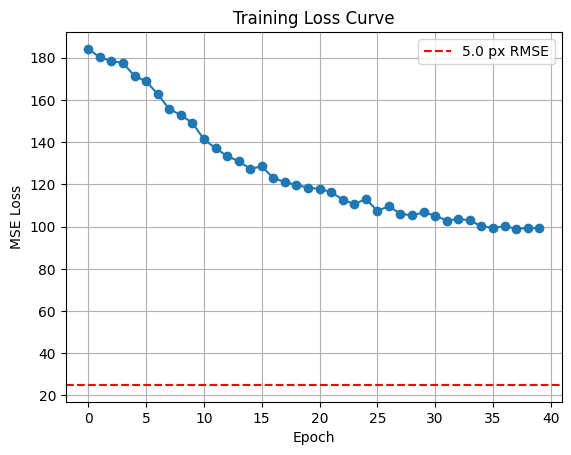

In [82]:
import matplotlib.pyplot as plt

losses = train(model, train_loader, optimizer, criterion, epochs=40)


plt.plot(losses, marker='o')
plt.title("Training Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.axhline(y=25, color='red', linestyle='--', label='5.0 px RMSE')
plt.legend()
plt.grid(True)
plt.show()


##**EVALUATION**

In [83]:
def evaluate(model, num_samples=1000):
    model.eval()
    test_dataset = OddXYDataset(num_samples)
    test_loader = DataLoader(test_dataset, batch_size=64)

    errors = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            preds = model(images)
            error = torch.sqrt(((preds - labels) ** 2).sum(dim=1))
            errors.extend(error.cpu().numpy())

    rmse = np.mean(errors)
    print(f"Test RMSE: {rmse:.3f} pixels")
    return rmse

evaluate(model, num_samples=1000)


Test RMSE: 10.304 pixels


np.float32(10.303532)

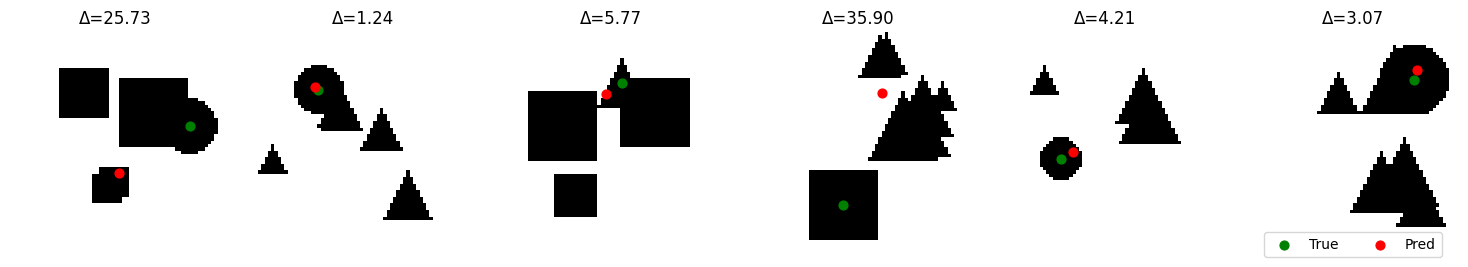

In [84]:
def visualize_predictions(model, dataset, num_examples=6):
    model.eval()
    loader = DataLoader(dataset, batch_size=num_examples)
    images, labels = next(iter(loader))
    preds = model(images.to(device)).cpu().detach()

    fig, axes = plt.subplots(1, num_examples, figsize=(num_examples * 2.5, 2.5))

    for i in range(num_examples):
        img = images[i].squeeze().numpy()
        true_x, true_y = labels[i]
        pred_x, pred_y = preds[i]

        axes[i].imshow(img, cmap="gray")
        axes[i].scatter(true_x, true_y, c="green", label="True", s=40)
        axes[i].scatter(pred_x, pred_y, c="red", label="Pred", s=40)
        axes[i].set_title(f"Δ={((pred_x-true_x)**2+(pred_y-true_y)**2).sqrt():.2f}")
        axes[i].axis("off")

    plt.legend(loc="lower center", bbox_to_anchor=(0.5, -0.1), ncol=2)
    plt.tight_layout()
    plt.show()

visualize_predictions(model, OddXYDataset(num_samples=100))

##**OFFSET REGRESSOR**

In [85]:
class OffsetRegressor(nn.Module):
    def __init__(self, hidden_dim=16):
        super().__init__()
        self.net = nn.Sequential(
          nn.Linear(16, 128),
          nn.ReLU(),
          nn.Linear(128, 2)
          )  # (Δx, Δy)


    def forward(self, x):  # x: [B, 144, 16]
        return self.net(x)  # [B, 144, 2]


##**NEW MODEL**

In [86]:
class ShapeAttentionModelV2(nn.Module):
    def __init__(self, pretrained_model=None):
        super().__init__()
        self.embedding = PatchEmbedding()
        self.pos_enc = PositionalEncoding()
        self.attn = SelfAttention()
        self.classifier = TokenClassifier()
        self.offset_head = OffsetRegressor()

        self.centers = compute_patch_centers()  # [144, 2]

        if pretrained_model:  # ← from phase 1
            self.embedding.load_state_dict(pretrained_model.embedding.state_dict())
            self.pos_enc.load_state_dict(pretrained_model.pos_enc.state_dict())
            self.attn.load_state_dict(pretrained_model.attn.state_dict())
            self.classifier.load_state_dict(pretrained_model.classifier.state_dict())

    def forward(self, x):
        x = self.embedding(x)               # [B, 144, 16]
        x = self.pos_enc(x)
        x = self.attn(x)

        logits = self.classifier(x)         # [B, 144]
        probs = torch.softmax(logits, dim=-1)  # [B, 144]

        coarse = soft_argmax(probs, self.centers)  # [B, 2]

        offsets = self.offset_head(x)       # [B, 144, 2]
        weighted_offset = torch.sum(probs.unsqueeze(-1) * offsets, dim=1)  # [B, 2]

        return coarse + weighted_offset     # Final prediction


In [87]:
model_v2 = ShapeAttentionModelV2(pretrained_model=model).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_v2.parameters(), lr=1e-3)
train_dataset = OddXYDataset(num_samples=20000)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

losses2 = train(model_v2, train_loader, optimizer, criterion, epochs=40)


Epoch 1/40: 100%|██████████| 313/313 [00:23<00:00, 13.28it/s]


Epoch 1 — Avg Loss: 95.8770


Epoch 2/40: 100%|██████████| 313/313 [00:23<00:00, 13.33it/s]


Epoch 2 — Avg Loss: 96.3572


Epoch 3/40: 100%|██████████| 313/313 [00:23<00:00, 13.20it/s]


Epoch 3 — Avg Loss: 95.4786


Epoch 4/40: 100%|██████████| 313/313 [00:23<00:00, 13.22it/s]


Epoch 4 — Avg Loss: 93.0766


Epoch 5/40: 100%|██████████| 313/313 [00:22<00:00, 14.00it/s]


Epoch 5 — Avg Loss: 94.3473


Epoch 6/40: 100%|██████████| 313/313 [00:23<00:00, 13.38it/s]


Epoch 6 — Avg Loss: 92.6408


Epoch 7/40: 100%|██████████| 313/313 [00:23<00:00, 13.44it/s]


Epoch 7 — Avg Loss: 93.4215


Epoch 8/40: 100%|██████████| 313/313 [00:23<00:00, 13.25it/s]


Epoch 8 — Avg Loss: 91.9520


Epoch 9/40: 100%|██████████| 313/313 [00:23<00:00, 13.28it/s]


Epoch 9 — Avg Loss: 90.8126


Epoch 10/40: 100%|██████████| 313/313 [00:23<00:00, 13.58it/s]


Epoch 10 — Avg Loss: 88.2588


Epoch 11/40: 100%|██████████| 313/313 [00:23<00:00, 13.60it/s]


Epoch 11 — Avg Loss: 90.1001


Epoch 12/40: 100%|██████████| 313/313 [00:23<00:00, 13.31it/s]


Epoch 12 — Avg Loss: 90.7848


Epoch 13/40: 100%|██████████| 313/313 [00:23<00:00, 13.27it/s]


Epoch 13 — Avg Loss: 88.5478


Epoch 14/40: 100%|██████████| 313/313 [00:23<00:00, 13.36it/s]


Epoch 14 — Avg Loss: 88.4280


Epoch 15/40: 100%|██████████| 313/313 [00:23<00:00, 13.30it/s]


Epoch 15 — Avg Loss: 86.3753


Epoch 16/40: 100%|██████████| 313/313 [00:22<00:00, 13.70it/s]


Epoch 16 — Avg Loss: 87.1444


Epoch 17/40: 100%|██████████| 313/313 [00:23<00:00, 13.21it/s]


Epoch 17 — Avg Loss: 85.0233


Epoch 18/40: 100%|██████████| 313/313 [00:24<00:00, 12.58it/s]


Epoch 18 — Avg Loss: 85.2718


Epoch 19/40: 100%|██████████| 313/313 [00:23<00:00, 13.17it/s]


Epoch 19 — Avg Loss: 85.2488


Epoch 20/40: 100%|██████████| 313/313 [00:23<00:00, 13.34it/s]


Epoch 20 — Avg Loss: 83.8468


Epoch 21/40: 100%|██████████| 313/313 [00:22<00:00, 13.66it/s]


Epoch 21 — Avg Loss: 86.6237


Epoch 22/40: 100%|██████████| 313/313 [00:23<00:00, 13.46it/s]


Epoch 22 — Avg Loss: 84.6053


Epoch 23/40: 100%|██████████| 313/313 [00:23<00:00, 13.35it/s]


Epoch 23 — Avg Loss: 85.4381


Epoch 24/40: 100%|██████████| 313/313 [00:23<00:00, 13.21it/s]


Epoch 24 — Avg Loss: 83.8360


Epoch 25/40: 100%|██████████| 313/313 [00:23<00:00, 13.25it/s]


Epoch 25 — Avg Loss: 85.2029


Epoch 26/40: 100%|██████████| 313/313 [00:23<00:00, 13.28it/s]


Epoch 26 — Avg Loss: 82.8764


Epoch 27/40: 100%|██████████| 313/313 [00:22<00:00, 13.77it/s]


Epoch 27 — Avg Loss: 84.2540


Epoch 28/40: 100%|██████████| 313/313 [00:23<00:00, 13.50it/s]


Epoch 28 — Avg Loss: 81.8540


Epoch 29/40: 100%|██████████| 313/313 [00:23<00:00, 13.19it/s]


Epoch 29 — Avg Loss: 82.9916


Epoch 30/40: 100%|██████████| 313/313 [00:23<00:00, 13.35it/s]


Epoch 30 — Avg Loss: 80.9269


Epoch 31/40: 100%|██████████| 313/313 [00:23<00:00, 13.38it/s]


Epoch 31 — Avg Loss: 81.8152


Epoch 32/40: 100%|██████████| 313/313 [00:22<00:00, 13.66it/s]


Epoch 32 — Avg Loss: 82.6979


Epoch 33/40: 100%|██████████| 313/313 [00:23<00:00, 13.56it/s]


Epoch 33 — Avg Loss: 81.3466


Epoch 34/40: 100%|██████████| 313/313 [00:23<00:00, 13.26it/s]


Epoch 34 — Avg Loss: 79.0124


Epoch 35/40: 100%|██████████| 313/313 [00:23<00:00, 13.34it/s]


Epoch 35 — Avg Loss: 81.9746


Epoch 36/40: 100%|██████████| 313/313 [00:23<00:00, 13.43it/s]


Epoch 36 — Avg Loss: 83.0504


Epoch 37/40: 100%|██████████| 313/313 [00:23<00:00, 13.34it/s]


Epoch 37 — Avg Loss: 80.4035


Epoch 38/40: 100%|██████████| 313/313 [00:22<00:00, 13.80it/s]


Epoch 38 — Avg Loss: 79.8841


Epoch 39/40: 100%|██████████| 313/313 [00:23<00:00, 13.42it/s]


Epoch 39 — Avg Loss: 79.8475


Epoch 40/40: 100%|██████████| 313/313 [00:23<00:00, 13.33it/s]

Epoch 40 — Avg Loss: 78.2425


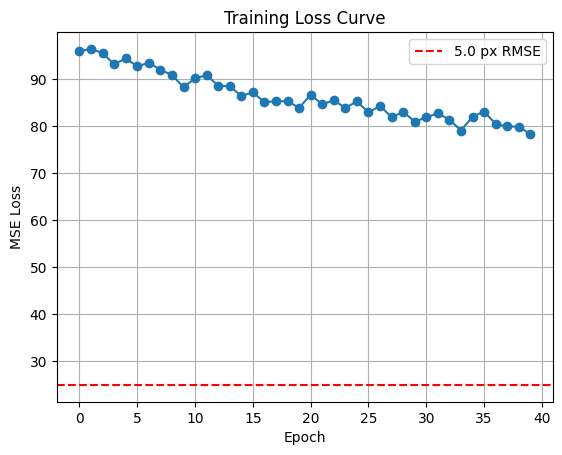

In [88]:
plt.plot(losses2, marker='o')
plt.title("Training Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.axhline(y=25, color='red', linestyle='--', label='5.0 px RMSE')
plt.legend()
plt.grid(True)
plt.show()

Test RMSE: 9.152 pixels


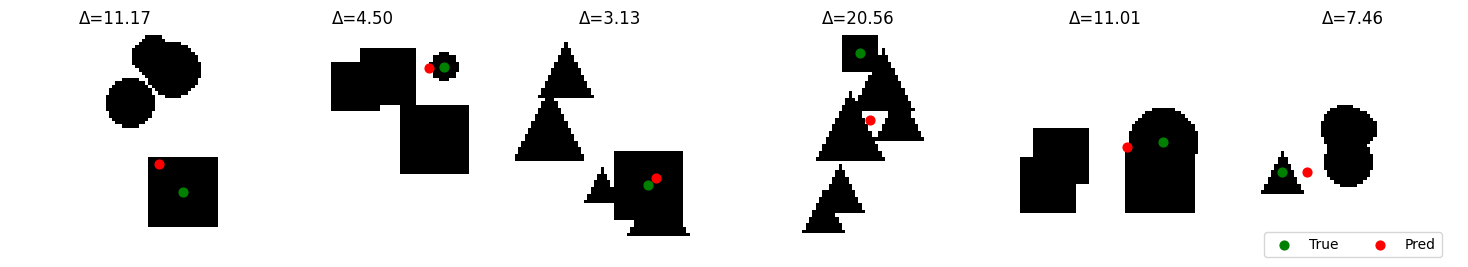

In [89]:
evaluate(model_v2, num_samples=1000)
visualize_predictions(model_v2, OddXYDataset(num_samples=6))

IndexError: index 10 is out of bounds for dimension 0 with size 4

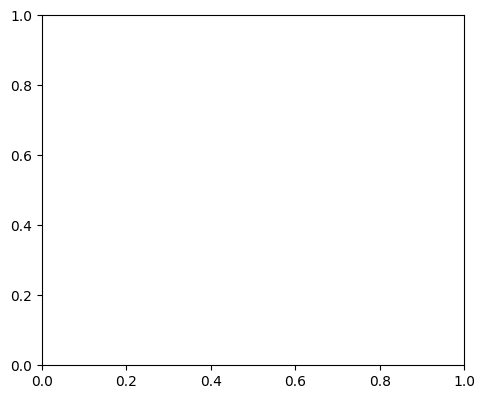

In [96]:
import matplotlib.pyplot as plt
import seaborn as sns

# Forward pass through the model (assuming img is [1, 1, 64, 64])
if img.ndim == 3:  # [C, H, W]
    x_batch = img.unsqueeze(0).to(device)  # [1, C, H, W]
elif img.ndim == 2:  # [H, W] (very rare)
    x_batch = img.unsqueeze(0).unsqueeze(0).to(device)  # [1, 1, H, W]
else:
    x_batch = img.to(device)  # already batched

_ = model(x_batch)

# Get attention weights: [1, 144, 144]
attn_weights = model.attn.attn_weights.cpu().squeeze(0)

query_tokens = [10, 40, 72, 100]  # random

num_tokens = len(query_tokens)
num_cols = 2
num_rows = (num_tokens + num_cols - 1) // num_cols

plt.figure(figsize=(num_cols * 6, num_rows * 5))

for i, query_token in enumerate(query_tokens):
    plt.subplot(num_rows, num_cols, i + 1)
    heat = attn_weights[query_token].reshape(12, 12)
    sns.heatmap(heat, cmap="viridis", cbar=True)
    plt.title(f"Attention from token #{query_token}")
    plt.xlabel("Key pos")
    plt.ylabel("Key pos")

plt.tight_layout()
plt.show()